In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import helper

# 加载图像数据

In [2]:
data_dir = './5-celebrity-faces-dataset'

#TODO: compose transforms here
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
# TODO: create the ImageFolder
dataset = datasets.ImageFolder(data_dir, transform=transform)
# TODO: use the ImageFolder dataset to create the DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [3]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
print(labels[0])

tensor(1)


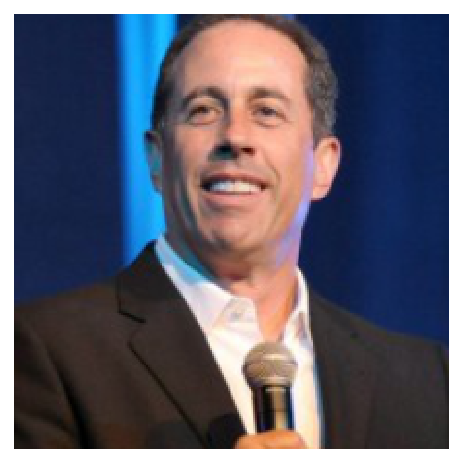

In [4]:
helper.imshow(images[0], normalize=False)

# 加载数据，数据增强

In [5]:
data_dir = '5-celebrity-faces-dataset'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/val', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16)

In [6]:
# change this to the trainloader or testloader 
data_iter = iter(testloader)

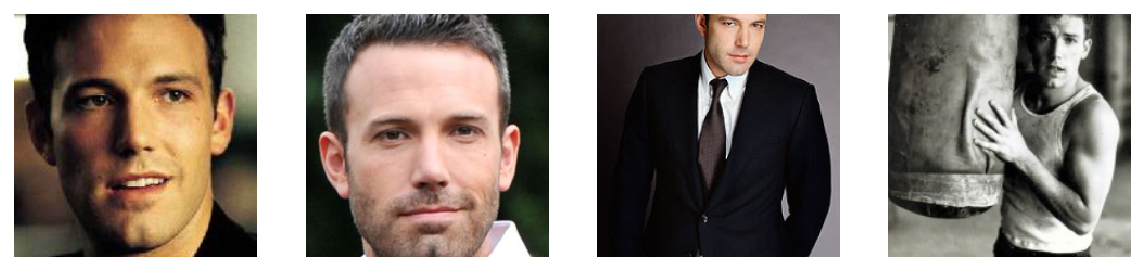

In [7]:
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [19]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 5)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [10]:
import time

In [11]:
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 0.337 seconds
Device = cuda; Time per batch: 0.005 seconds


You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [12]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

In [13]:
def test_model(my_model,my_device, my_epochs, my_trainloader, my_testloader):
    steps = 0
    running_loss = 0
    print_every = 5
    
    my_criterion = nn.NLLLoss()
    my_optimizer = optim.Adam(my_model.classifier.parameters(),lr=0.003)
    

    my_model.to(my_device)

    for epoch in range(my_epochs):
        for inputs,labels in my_trainloader:
            steps += 1
            inputs,labels = inputs.to(my_device),labels.to(my_device)

            my_optimizer.zero_grad()
            logps = my_model.forward(inputs)
            loss = my_criterion(logps, labels)
            loss.backward()
            my_optimizer.step()

            running_loss += float(loss.item())
            del inputs
            del labels

            if steps%print_every == 0:
                test_loss = 0
                accuracy = 0
                my_model.eval()
                with torch.no_grad():
                    for inputs,labels in my_testloader:
                        inputs,labels = inputs.to(my_device),labels.to(my_device)
                        logps = my_model.forward(inputs)
                        batch_loss = my_criterion(logps, labels)

                        test_loss += float(batch_loss.item())

                        #Caculate accuracy
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1,dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(f"Epoch {epoch+1}/{my_epochs}.. "
                      f"step: {steps}..."
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Test loss: {test_loss/len(my_testloader):.3f}.. "
                      f"Test accuracy: {accuracy/len(my_testloader):.3f}")
                running_loss = 0
                if accuracy/len(testloader) > 0.94:
                    torch.cuda.empty_cache()
                    break
                my_model.train()
           
    torch.cuda.empty_cache()

In [14]:
torch.cuda.empty_cache()
import time
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
model_type = models.densenet121(pretrained=True)

In [16]:
for param in model_type.parameters():
    param.requires_grad = False
    
model_type.classifier = nn.Sequential(nn.Linear(1024,256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256,5),
                                 nn.LogSoftmax(dim=1))

In [18]:
EPOCHS = 30
start = time.time()
test_model(model_type,device,EPOCHS,trainloader,testloader)
print(f"Device = {device}; model_type='densenet121',Time per batch: {(time.time() - start):.3f} seconds")

Epoch 1/30.. step: 5...Train loss: 2.351.. Test loss: 2.087.. Test accuracy: 0.250
Epoch 2/30.. step: 10...Train loss: 1.827.. Test loss: 1.633.. Test accuracy: 0.125
Epoch 3/30.. step: 15...Train loss: 1.644.. Test loss: 1.591.. Test accuracy: 0.198
Epoch 4/30.. step: 20...Train loss: 1.616.. Test loss: 1.583.. Test accuracy: 0.278
Epoch 5/30.. step: 25...Train loss: 1.584.. Test loss: 1.580.. Test accuracy: 0.278
Epoch 5/30.. step: 30...Train loss: 1.572.. Test loss: 1.578.. Test accuracy: 0.278
Epoch 6/30.. step: 35...Train loss: 1.631.. Test loss: 1.580.. Test accuracy: 0.278
Epoch 7/30.. step: 40...Train loss: 1.619.. Test loss: 1.579.. Test accuracy: 0.278
Epoch 8/30.. step: 45...Train loss: 1.607.. Test loss: 1.578.. Test accuracy: 0.278
Epoch 9/30.. step: 50...Train loss: 1.584.. Test loss: 1.577.. Test accuracy: 0.278
Epoch 10/30.. step: 55...Train loss: 1.580.. Test loss: 1.576.. Test accuracy: 0.278
Epoch 10/30.. step: 60...Train loss: 1.543.. Test loss: 1.576.. Test accurac